# What to expect from this notebook<a id="top"></a>

- an example of using of satellites to detect changes in plant life.
- very basic xarray manipulations
- removing clouds and patching scanlines
- building a composite image

<br>  

# Algorithmic process  

- [get the maximum extents of the datacube](#extents)
- [define extents you require that fall within the maximum extents](#define_extents)
    [* selecting too much can make the acquisition process slow ]
- [filter out cloud data and scan lines](#clean_mask)
- [select the dates you wish to form a baseline measure from and the target date for comparison](#baseline)
- [compare the target date's NDVI values against the baseline composite image](#compare)
- [plot the results](#plot)

<hr>
# How It Works

To detect changes in plant life, we use a measure called NDVI. 
* <font color=green>NDVI</font> is the ratio of the difference between amount of near infrared light <font color=red>(NIR)</font> and red light <font color=red>(RED)</font> divided by their sum.
<br>

$$ NDVI =  \frac{(NIR - RED)}{(NIR + RED)}$$  

<br>
<div class="alert-info">
The idea is to observe how much red light is being absorbed versus reflected. Photosynthetic plants absorb most of the visible spectrum's wavelengths when they are healthy.  When they aren't healthy, more of that light will get reflected.  This makes the difference between <font color=red>NIR</font> and <font color=red>RED</font> much smaller which will lower the <font color=green>NDVI</font>.  The resulting values from doing this over several pixels can be used to create visualizations for the changes in the amount of photosynthetic vegetation in large areas.
</div>

In [1]:
#Import the datacube and the API
import datacube
from utils.data_cube_utilities.data_access_api import DataAccessApi

#Create an instance of the datacube and API
dc = datacube.Datacube(config="/home/localuser/.datacube.conf")
api = DataAccessApi(config="/home/localuser/.datacube.conf")

In [2]:
#Get all the current datacube products
products = dc.list_products()

#List the LANDSAT 7 products
print(products[["platform", "name"]][products.platform == "LANDSAT_7"])

     platform                           name
id                                          
8   LANDSAT_7       ls7_collections_sr_scene
70  LANDSAT_7  ls7_collections_sr_scene_lean
19  LANDSAT_7        ls7_ledaps_amazon_river
20  LANDSAT_7          ls7_ledaps_bangladesh
35  LANDSAT_7     ls7_ledaps_bangladesh_bari
36  LANDSAT_7             ls7_ledaps_caqueta
21  LANDSAT_7            ls7_ledaps_colombia
22  LANDSAT_7               ls7_ledaps_ghana
23  LANDSAT_7               ls7_ledaps_kenya
41  LANDSAT_7        ls7_ledaps_lake_baringo
24  LANDSAT_7      ls7_ledaps_lake_chad_full
25  LANDSAT_7        ls7_ledaps_lake_cortijo
26  LANDSAT_7      ls7_ledaps_menindee_lakes
27  LANDSAT_7          ls7_ledaps_meta_river
62  LANDSAT_7              ls7_ledaps_mexico
28  LANDSAT_7     ls7_ledaps_salgar_colombia
72  LANDSAT_7          ls7_ledaps_sanagustin
63  LANDSAT_7               ls7_ledaps_scene
29  LANDSAT_7                ls7_ledaps_togo
30  LANDSAT_7               ls7_ledaps_tonga
31  LANDSA

In [3]:
#This are the platform (satellite) and product (datacube set) used for this demonstration
platform = ["LANDSAT_7"]
product = ["ls7_ledaps_kenya"]

The magnitudes of the different wavelengths of light can be quanitized and stored on a per pixel basis.  <font color=green>NDVI</font> only requires the use of <font color=red>NIR</font> and <font color=red>RED</font> light but there are many more wavelengths and some additional measures available.  One such additional measure is called <font color=darkblue>pixel_qa</font>.  This is a measure of the quality of the pixel for analysis. A breakdown of the values stored in <font color=darkblue>pixel_qa</font> are beyond the scope of this notebook but we encourage you to check our github for more information on the meaning behind the values stored within.
![](diagrams/rainy_demo/ls7_xarray.png)  

## <a id="extents">Getting the Extents of the Cube</a>

In [4]:
# Get the extents of the cube
descriptor = api.get_query_metadata(platform=platform, product=product[0])

#store the latitudinal and longitudinal extents
lat, lon = products.resolution[products.platform == platform[0]].any()

In [5]:
from utils.data_cube_utilities.dc_display_map import display_map

#save extents
min_date, max_date = descriptor['time_extents']
min_lat, max_lat = descriptor['lat_extents']
min_lon, max_lon = descriptor['lon_extents']

#Adjust date string
min_date_str = str(min_date.year) + '-' + str(min_date.month) + '-' + str(min_date.day)
max_date_str = str(max_date.year) + '-' + str(max_date.month) + '-' + str(max_date.day)

#Round GPS coordinates to 3 decimal places
min_lat_rounded = round(min_lat, 3)
min_lon_rounded =  round(min_lon, 3)
max_lat_rounded = round(max_lat, 3)
max_lon_rounded = round(max_lon, 3) 

#display the total area available in this datacube product that can be used for analysis
display_map(latitude = (min_lat_rounded, max_lat_rounded),longitude = (min_lon_rounded, max_lon_rounded))

In [6]:
from dc_notebook_utilities import generate_metadata_report

# Display the ranges of the datacube in a table
generate_metadata_report(min_date_str, max_date_str, 
                         min_lon_rounded, max_lon_rounded, lon,
                         min_lat_rounded, max_lat_rounded, lat)

'Basemap' was not found in 'mpl_toolkits.basemap'.  It is likely that 'mpl_toolkits.basemap' is not present


,Min,Max,Resolution
Date:,2005-1-8,2016-12-24,
Longitude:,34.655,36.899,0.000269995
Latitude:,-0.942,0.95,-0.000271302


## <a id="define_extents">Defining the Extents of the Analysis</a>

In [12]:
from dc_notebook_utilities import create_extents_gui 

#Create the GUI for the extents derived
extent_values = create_extents_gui(min_date_str, max_date_str,
                                   min_lon_rounded, max_lon_rounded,
                                   min_lat_rounded, max_lat_rounded)

#for the demonstration we will use the following extents:
# Lon: 35.5 to 35.7
# Lat: .5 to .7

Label(value='Start date: ')

Text(value='2005-1-8')

Label(value='End date: ')

Text(value='2016-12-24')

Label(value='Min lon: ')

BoundedFloatText(value=34.655, max=36.899, min=34.655)

Label(value='Max lon: ')

BoundedFloatText(value=36.899, max=36.899, min=34.655)

Label(value='Min lat: ')

BoundedFloatText(value=-0.942, max=0.95, min=-0.942)

Label(value='Max lat: ')

BoundedFloatText(value=0.95, max=0.95, min=-0.942)

While Latitude and Longitude are pretty straightforward, time slices must be chosen carefully so that you do not accidentally obscure useful information.  In the diagram below you can see that the rainy season is omitted so the composites can be representative of the dry seasons on either side of the rainy season.  The inclusion of the rainy season data would obscure the analysis results.
![img](diagrams/rainy_demo/alg_jn2_02.png)


In [8]:
import datetime

# Save form values
start_date = datetime.datetime.strptime(extent_values[0].value, '%Y-%m-%d')
end_date = datetime.datetime.strptime(extent_values[1].value, '%Y-%m-%d')
min_lon = extent_values[2].value
max_lon = extent_values[3].value
min_lat = extent_values[4].value
max_lat = extent_values[5].value

#get a list of available image aquisition dates
acquisitions_list = api.list_acquisition_dates(product[0], longitude=(min_lon, max_lon), latitude=(min_lat, max_lat))
print(len(acquisitions_list))

174


In [9]:
#define query parameters
params= dict(platform=platform[0],
             product=product[0],
             lon=(min_lon, max_lon),
             lat=(min_lat, max_lat),
             measurements = ["red", "nir", "pixel_qa"])

# Query the Data Cube
dataset = dc.load(**params)

## <a id="clean_mask">Making a Clean Mask</a>

#### Clouds:
Clouds can obscure imagery from satellites making the analysis harder to perform.  Fortunately clouds can be filtered out rather easily using images from other dates close to the target date.  The small illustration below shows how clouds can obsure a satellite image:
  ![](diagrams/rainy_demo/cloud_clip_01.PNG)

#### Scan Lines:
Scan lines are an artifact of Landsat satellite imagery.  They are a result of a malfunction in the system responsible for ensuring full coverage.  As a result there are missing strips of imagery from most Landsat images.  The illsutration below shows what scan lines might look like on a satellite image:
![](diagrams/rainy_demo/slc_error_02.PNG)

In [10]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask

#Get the clean mask for the LANDSAT satellite platform
clean_mask = landsat_qa_clean_mask(dataset, platform[0])

In [13]:
from utils.data_cube_utilities.dc_mosaic import create_mosaic
#Apply clean mask to dataset
cleaned_dataset = create_mosaic(dataset, reverse_time=False, clean_mask=clean_mask)

# <a id="baseline">Selecting a Target Date and Specifying a Baseline For Comparison</a>

In [14]:
from ipywidgets import widgets
import collections
import operator
from utils.data_cube_utilities.dc_mosaic import (create_mosaic, create_median_mosaic,
                                                 create_max_ndvi_mosaic, create_min_ndvi_mosaic)


#create the widget for the scene selection dropdown
#This will be used to select the scene we are comparing to the baseline NDVI amounts
scene_sel = widgets.Dropdown(options=acquisitions_list, values=acquisitions_list)

#This dropdown widget will allow us to select multiple scenes with which to compose a baseline
baseline_sel = widgets.SelectMultiple(options=acquisitions_list, values=acquisitions_list)

#Set the threshold increment and create the dropdown for it
threshold_sel_options = {str(x)+'%': x/100 for x in range(5, 101, 5)}
threshold_sel = widgets.Dropdown(options=collections.OrderedDict(sorted(threshold_sel_options.items(), key=operator.itemgetter(1))))

#Create a dictionary of the different mosaic method options
mosaic_methods = {'Most Recent':create_mosaic, 'Least Recent':create_mosaic,'Median':create_median_mosaic,
                  'Max NDVI':create_max_ndvi_mosaic, 'Min NDVI':create_min_ndvi_mosaic}

#create the widget for the mosaic options
mosaic_options_sel = widgets.Dropdown(options=list(mosaic_methods.keys()))
    
# Display form
display(widgets.Label('Select a scene to check for anomalies: '), scene_sel)
display(widgets.Label('Select scenes to form a baseline: '), baseline_sel)
display(widgets.Label('Select a mosaic method for the baseline:  '), mosaic_options_sel)
display(widgets.Label('Select a percentage threshold for anomalies: '), threshold_sel)

Label(value='Select a scene to check for anomalies: ')

Dropdown(options=(datetime.datetime(2005, 1, 8, 7, 38, 21), datetime.datetime(2005, 1, 24, 7, 38, 21), datetime.datetime(2005, 2, 25, 7, 38, 37), datetime.datetime(2005, 3, 13, 7, 38, 40), datetime.datetime(2005, 3, 29, 7, 38, 38), datetime.datetime(2005, 4, 14, 7, 38, 32), datetime.datetime(2005, 5, 16, 7, 38, 34), datetime.datetime(2005, 6, 1, 7, 38, 31), datetime.datetime(2005, 6, 17, 7, 38, 24), datetime.datetime(2005, 7, 3, 7, 38, 22), datetime.datetime(2005, 8, 4, 7, 38, 21), datetime.datetime(2005, 9, 5, 7, 38, 7), datetime.datetime(2005, 9, 21, 7, 38, 2), datetime.datetime(2005, 10, 7, 7, 37, 57), datetime.datetime(2006, 1, 11, 7, 38, 48), datetime.datetime(2006, 1, 27, 7, 38, 56), datetime.datetime(2006, 2, 12, 7, 39, 1), datetime.datetime(2006, 2, 28, 7, 39, 3), datetime.datetime(2006, 4, 1, 7, 39, 2), datetime.datetime(2006, 5, 3, 7, 39, 1), datetime.datetime(2006, 5, 19, 7, 39, 2), datetime.datetime(2006, 6, 4, 7, 39), datetime.datetime(2006, 10, 10, 7, 38, 21), datetime.datetime(2006, 11, 11, 7, 38, 51), datetime.datetime(2006, 12, 13, 7, 39, 7), datetime.datetime(2007, 2, 15, 7, 39, 23), datetime.datetime(2007, 3, 3, 7, 39, 27), datetime.datetime(2007, 3, 19, 7, 39, 29), datetime.datetime(2007, 4, 4, 7, 39, 29), datetime.datetime(2007, 4, 20, 7, 39, 27), datetime.datetime(2007, 5, 6, 7, 39, 23), datetime.datetime(2007, 5, 22, 7, 39, 16), datetime.datetime(2007, 6, 7, 7, 39, 13), datetime.datetime(2007, 7, 9, 7, 39, 11), datetime.datetime(2007, 8, 10, 7, 39, 2), datetime.datetime(2007, 8, 26, 7, 38, 55), datetime.datetime(2007, 9, 27, 7, 38, 43), datetime.datetime(2007, 10, 13, 7, 38, 43), datetime.datetime(2007, 10, 29, 7, 38, 55), datetime.datetime(2007, 11, 14, 7, 39, 4), datetime.datetime(2007, 11, 30, 7, 39, 11), datetime.datetime(2007, 12, 16, 7, 39, 16), datetime.datetime(2008, 1, 1, 7, 39, 18), datetime.datetime(2008, 3, 5, 7, 39, 8), datetime.datetime(2008, 4, 6, 7, 39, 6), datetime.datetime(2008, 8, 28, 7, 38, 1), datetime.datetime(2008, 9, 13, 7, 37, 53), datetime.datetime(2008, 9, 29, 7, 37, 44), datetime.datetime(2008, 10, 15, 7, 37, 38), datetime.datetime(2008, 10, 31, 7, 37, 54), datetime.datetime(2008, 11, 16, 7, 38, 8), datetime.datetime(2008, 12, 18, 7, 38, 29), datetime.datetime(2009, 1, 3, 7, 38, 35), datetime.datetime(2009, 1, 19, 7, 38, 41), datetime.datetime(2009, 2, 4, 7, 38, 45), datetime.datetime(2009, 2, 20, 7, 38, 55), datetime.datetime(2009, 3, 8, 7, 39, 4), datetime.datetime(2009, 3, 24, 7, 39, 11), datetime.datetime(2009, 4, 9, 7, 39, 16), datetime.datetime(2009, 4, 25, 7, 39, 21), datetime.datetime(2009, 6, 12, 7, 39, 23), datetime.datetime(2009, 6, 28, 7, 39, 21), datetime.datetime(2009, 7, 14, 7, 39, 17), datetime.datetime(2009, 7, 30, 7, 39, 12), datetime.datetime(2009, 8, 31, 7, 39, 8), datetime.datetime(2009, 9, 16, 7, 39, 7), datetime.datetime(2009, 10, 2, 7, 39, 4), datetime.datetime(2009, 12, 21, 7, 40, 4), datetime.datetime(2010, 1, 6, 7, 40, 20), datetime.datetime(2010, 1, 22, 7, 40, 35), datetime.datetime(2010, 4, 12, 7, 41, 10), datetime.datetime(2010, 4, 28, 7, 41, 9), datetime.datetime(2010, 5, 30, 7, 41, 5), datetime.datetime(2010, 7, 17, 7, 41, 11), datetime.datetime(2010, 8, 2, 7, 41, 10), datetime.datetime(2010, 8, 18, 7, 41, 11), datetime.datetime(2010, 9, 3, 7, 41, 14), datetime.datetime(2010, 10, 5, 7, 41, 13), datetime.datetime(2011, 2, 10, 7, 42, 23), datetime.datetime(2011, 2, 26, 7, 42, 28), datetime.datetime(2011, 3, 30, 7, 42, 34), datetime.datetime(2011, 4, 15, 7, 42, 34), datetime.datetime(2011, 8, 21, 7, 42, 21), datetime.datetime(2011, 9, 22, 7, 42, 13), datetime.datetime(2011, 10, 8, 7, 42, 10), datetime.datetime(2011, 12, 11, 7, 42, 44), datetime.datetime(2012, 1, 12, 7, 42, 59), datetime.datetime(2012, 1, 28, 7, 42, 59), datetime.datetime(2012, 2, 13, 7, 43, 5), datetime.datetime(2012, 5, 19, 7, 43, 39), datetime.datetime(2012, 6, 4, 7, 43, 18), datetime.datetime(2012, 9, 8, 7, 44, 21), datetime.datetime(2012, 9, 24, 7, 44, 30), datetime.datetime(20

Label(value='Select scenes to form a baseline: ')

SelectMultiple(options=(datetime.datetime(2005, 1, 8, 7, 38, 21), datetime.datetime(2005, 1, 24, 7, 38, 21), datetime.datetime(2005, 2, 25, 7, 38, 37), datetime.datetime(2005, 3, 13, 7, 38, 40), datetime.datetime(2005, 3, 29, 7, 38, 38), datetime.datetime(2005, 4, 14, 7, 38, 32), datetime.datetime(2005, 5, 16, 7, 38, 34), datetime.datetime(2005, 6, 1, 7, 38, 31), datetime.datetime(2005, 6, 17, 7, 38, 24), datetime.datetime(2005, 7, 3, 7, 38, 22), datetime.datetime(2005, 8, 4, 7, 38, 21), datetime.datetime(2005, 9, 5, 7, 38, 7), datetime.datetime(2005, 9, 21, 7, 38, 2), datetime.datetime(2005, 10, 7, 7, 37, 57), datetime.datetime(2006, 1, 11, 7, 38, 48), datetime.datetime(2006, 1, 27, 7, 38, 56), datetime.datetime(2006, 2, 12, 7, 39, 1), datetime.datetime(2006, 2, 28, 7, 39, 3), datetime.datetime(2006, 4, 1, 7, 39, 2), datetime.datetime(2006, 5, 3, 7, 39, 1), datetime.datetime(2006, 5, 19, 7, 39, 2), datetime.datetime(2006, 6, 4, 7, 39), datetime.datetime(2006, 10, 10, 7, 38, 21), datetime.datetime(2006, 11, 11, 7, 38, 51), datetime.datetime(2006, 12, 13, 7, 39, 7), datetime.datetime(2007, 2, 15, 7, 39, 23), datetime.datetime(2007, 3, 3, 7, 39, 27), datetime.datetime(2007, 3, 19, 7, 39, 29), datetime.datetime(2007, 4, 4, 7, 39, 29), datetime.datetime(2007, 4, 20, 7, 39, 27), datetime.datetime(2007, 5, 6, 7, 39, 23), datetime.datetime(2007, 5, 22, 7, 39, 16), datetime.datetime(2007, 6, 7, 7, 39, 13), datetime.datetime(2007, 7, 9, 7, 39, 11), datetime.datetime(2007, 8, 10, 7, 39, 2), datetime.datetime(2007, 8, 26, 7, 38, 55), datetime.datetime(2007, 9, 27, 7, 38, 43), datetime.datetime(2007, 10, 13, 7, 38, 43), datetime.datetime(2007, 10, 29, 7, 38, 55), datetime.datetime(2007, 11, 14, 7, 39, 4), datetime.datetime(2007, 11, 30, 7, 39, 11), datetime.datetime(2007, 12, 16, 7, 39, 16), datetime.datetime(2008, 1, 1, 7, 39, 18), datetime.datetime(2008, 3, 5, 7, 39, 8), datetime.datetime(2008, 4, 6, 7, 39, 6), datetime.datetime(2008, 8, 28, 7, 38, 1), datetime.datetime(2008, 9, 13, 7, 37, 53), datetime.datetime(2008, 9, 29, 7, 37, 44), datetime.datetime(2008, 10, 15, 7, 37, 38), datetime.datetime(2008, 10, 31, 7, 37, 54), datetime.datetime(2008, 11, 16, 7, 38, 8), datetime.datetime(2008, 12, 18, 7, 38, 29), datetime.datetime(2009, 1, 3, 7, 38, 35), datetime.datetime(2009, 1, 19, 7, 38, 41), datetime.datetime(2009, 2, 4, 7, 38, 45), datetime.datetime(2009, 2, 20, 7, 38, 55), datetime.datetime(2009, 3, 8, 7, 39, 4), datetime.datetime(2009, 3, 24, 7, 39, 11), datetime.datetime(2009, 4, 9, 7, 39, 16), datetime.datetime(2009, 4, 25, 7, 39, 21), datetime.datetime(2009, 6, 12, 7, 39, 23), datetime.datetime(2009, 6, 28, 7, 39, 21), datetime.datetime(2009, 7, 14, 7, 39, 17), datetime.datetime(2009, 7, 30, 7, 39, 12), datetime.datetime(2009, 8, 31, 7, 39, 8), datetime.datetime(2009, 9, 16, 7, 39, 7), datetime.datetime(2009, 10, 2, 7, 39, 4), datetime.datetime(2009, 12, 21, 7, 40, 4), datetime.datetime(2010, 1, 6, 7, 40, 20), datetime.datetime(2010, 1, 22, 7, 40, 35), datetime.datetime(2010, 4, 12, 7, 41, 10), datetime.datetime(2010, 4, 28, 7, 41, 9), datetime.datetime(2010, 5, 30, 7, 41, 5), datetime.datetime(2010, 7, 17, 7, 41, 11), datetime.datetime(2010, 8, 2, 7, 41, 10), datetime.datetime(2010, 8, 18, 7, 41, 11), datetime.datetime(2010, 9, 3, 7, 41, 14), datetime.datetime(2010, 10, 5, 7, 41, 13), datetime.datetime(2011, 2, 10, 7, 42, 23), datetime.datetime(2011, 2, 26, 7, 42, 28), datetime.datetime(2011, 3, 30, 7, 42, 34), datetime.datetime(2011, 4, 15, 7, 42, 34), datetime.datetime(2011, 8, 21, 7, 42, 21), datetime.datetime(2011, 9, 22, 7, 42, 13), datetime.datetime(2011, 10, 8, 7, 42, 10), datetime.datetime(2011, 12, 11, 7, 42, 44), datetime.datetime(2012, 1, 12, 7, 42, 59), datetime.datetime(2012, 1, 28, 7, 42, 59), datetime.datetime(2012, 2, 13, 7, 43, 5), datetime.datetime(2012, 5, 19, 7, 43, 39), datetime.datetime(2012, 6, 4, 7, 43, 18), datetime.datetime(2012, 9, 8, 7, 44, 21), datetime.datetime(2012, 9, 24, 7, 44, 30), datetime.datet

Label(value='Select a mosaic method for the baseline:  ')

Dropdown(options=('Min NDVI', 'Median', 'Max NDVI', 'Most Recent', 'Least Recent'), value='Min NDVI')

Label(value='Select a percentage threshold for anomalies: ')

Dropdown(options=OrderedDict([('5%', 0.05), ('10%', 0.1), ('15%', 0.15), ('20%', 0.2), ('25%', 0.25), ('30%', 0.3), ('35%', 0.35), ('40%', 0.4), ('45%', 0.45), ('50%', 0.5), ('55%', 0.55), ('60%', 0.6), ('65%', 0.65), ('70%', 0.7), ('75%', 0.75), ('80%', 0.8), ('85%', 0.85), ('90%', 0.9), ('95%', 0.95), ('100%', 1.0)]), value=0.05)

In [15]:
#Initialize baseline mosaic for comparison
baseline_mosaic = None

#need to reverse the direction of the mosaicing over time if "Most Recent" selected
reverse_time = True if mosaic_options_sel.value.title() == 'Most Recent' else False
for index in range(len(baseline_sel.value)):
    data = api.get_dataset_by_extent(product[0], latitude=(min_lat, max_lat), longitude=(min_lon, max_lon), 
                                    time=(baseline_sel.value[index],(baseline_sel.value[index+1] if index != len(baseline_sel.value)-1 else baseline_sel.value[index]+datetime.timedelta(seconds=1))),
                                    measurements=['red', 'nir', 'pixel_qa'])
    clean_mask = landsat_qa_clean_mask(data, platform[0])
    baseline_mosaic = mosaic_methods[mosaic_options_sel.value](data, intermediate_product=baseline_mosaic, reverse_time=reverse_time, clean_mask=clean_mask)

## <a id="compare">Calulating the NDVI for the Baseline and Target Scene</a>

In [16]:
import sys #required for epsilon (in case the baseline is zero)

#Calculate the NDVI baseline values
ndvi_baseline = (baseline_mosaic.nir - baseline_mosaic.red) / (baseline_mosaic.nir + baseline_mosaic.red)

#Calculate the NDVI values in the target scene
ndvi_scene = (cleaned_dataset.nir - cleaned_dataset.red) / (cleaned_dataset.nir + cleaned_dataset.red)

#Determine the percentage change
percentage_change = abs((ndvi_baseline - ndvi_scene) / (ndvi_baseline+sys.float_info.epsilon))

## <a id="plot">Plotting the NDVI Anomalies</a>

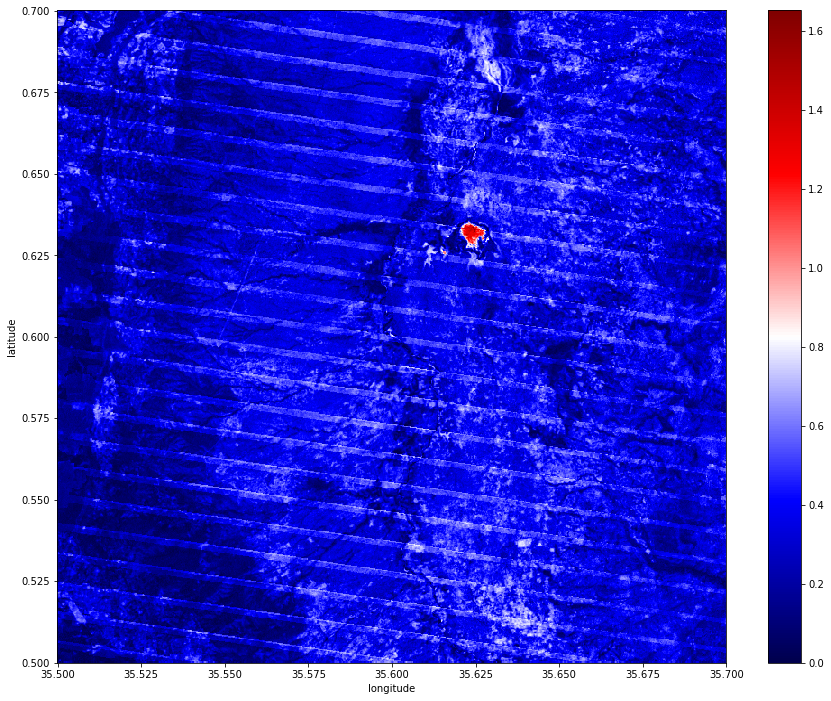

In [17]:
import matplotlib.pyplot as plt

#Set plot size
plt.figure(figsize = (15,12))

#plot the raw percent changes
percentage_change.plot(cmap='seismic')

In the plot above you can clearly see an anomaly of NDVI.  This indicates that there was a measurable difference in the amount of photosynthetic plants in the area compared to the standard defined in the baseline composite image.

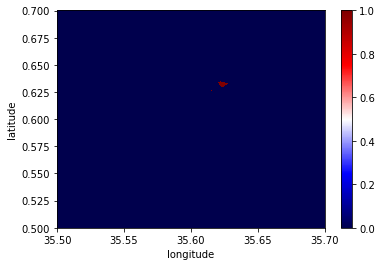

In [18]:
#with a hard cutoff value
anom = percentage_change > 1 

#display plot
anom.plot(cmap='seismic')

In [19]:
#Let's see what that area is
display_map(latitude = (.5, .7),longitude = (35.5, 35.7))

It turns out that the anomaly we detected was Lake Kamnarok in Kenya.  So why did lake Kamnarok show up as an anomaly?  It turns out that Lake Kamnarok, named after all the <i>Narok</i> plants in it, dried up in 2015. When it did, a significant number of the plants inside and around it died.  Without any prior knowledge about the lake, we were able to determine that there was a significant change in the plant life there using satellite imagery.

 
[return to top](#top)